# K-Means
To gain a better perspective on similarities based on select features.

In [11]:
# imports
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import afinn

In [265]:
# load data
subreddit = 'askreddit'
data = pd.read_json('../data/{0}-m100.json'.format(subreddit))
data['distinguished'] = data['distinguished'].fillna(value='none')

In [266]:
# compute boundaries
def compute_bounds(data):
    res  = dict()
    P_90 = np.percentile(data,90)
    # excluding forall d <= 0
    log_data = np.log([d for d in data if d > P_90])
    res['INSIGNIFICANT'] = np.exp(np.percentile(log_data, 0)) # equivalent to np.percentile(data, 90)
    res['NOTABLE']       = np.exp(np.percentile(log_data, 60))
    res['SIGNIFICANT']   = np.exp(np.percentile(log_data, 90))
    res['POPULAR']       = np.exp(np.percentile(log_data, 99.0))
    # implicit 'VERY POPULAR'
    return res
    
# autocategorization
def categorize(d, bounds):
    # try all categories
    for cat, val in bounds.items():
        if d < val:
            return cat
    # if at this point, VERY POPULAR
    return 'VERY POPULAR'

In [267]:
# clean + add some extra features
afinn_nlp = afinn.Afinn(language='en', emoticons=True)
data['sentiment']  = data['body'].apply(lambda text: afinn_nlp.score(text))
data['word_count'] = data['body'].apply(lambda text: len(text.split(' ')))
data['char_count'] = data['body'].apply(lambda text: len(text))
data['distinguished'] = data['distinguished'].fillna(value='none')

bounds = compute_bounds(data['score'])
data['score_cat']  = data['score'].apply(lambda score: categorize(score, bounds))

# drop useless columns (just like in playground.ipynb)
cols_to_drop = ['id', 'parent_id', 'top_level', 'created_utc', 'body', 'score', 'score_cat']
Y = data['score_cat']
X_pre = data.drop(columns=cols_to_drop)

In [268]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# pipeline to scale and encode our data
features = data.drop(columns=cols_to_drop)
full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), list(features.select_dtypes(include=[np.number]))),
    ('cat', OneHotEncoder(), list(features.select_dtypes(include=[np.object]).columns))
])

# order changes after pipelining
columns = list(features.select_dtypes(include=[np.number])) + \
          list(features.select_dtypes(include=[np.object]).columns)
print(columns)

# run through pipeline
X = full_pipeline.fit_transform(X_pre)

['depth', 'time_dff', 'gilds', 'sentiment', 'word_count', 'char_count', 'distinguished']


In [269]:
# see: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# create a K-Means classifier, but all we really care about is how it chooses to cluster its datapoints
N = 5
clf = KMeans(n_clusters=N)
clf.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Provided there are $n > 3$ features, we have a limited ability to fully visualize our cluster assignments. The best we can do in terms of plotting is choosing the 3 most interesting features.

In [270]:
# NOTE: after transforming, the ordering of columns changes depending on ColumnTransformer configuration
print(list(X_pre.columns))
print(columns)

['depth', 'time_dff', 'gilds', 'distinguished', 'sentiment', 'word_count', 'char_count']
['depth', 'time_dff', 'gilds', 'sentiment', 'word_count', 'char_count', 'distinguished']


A more modular way to choose our categories for axes $x$, $y$, and $z$...

In [271]:
# dictionary of axes names to column index (i.e X[:,cat_id[i]])
cat_id = dict(zip(columns, range(len(columns))))
xlab = 'time_dff'
ylab = 'word_count'
zlab = 'gilds'
# category validity check
assert all([i in X_pre.columns for i in (xlab,ylab,zlab)]),\
    'All chosen axes must be valid categories'

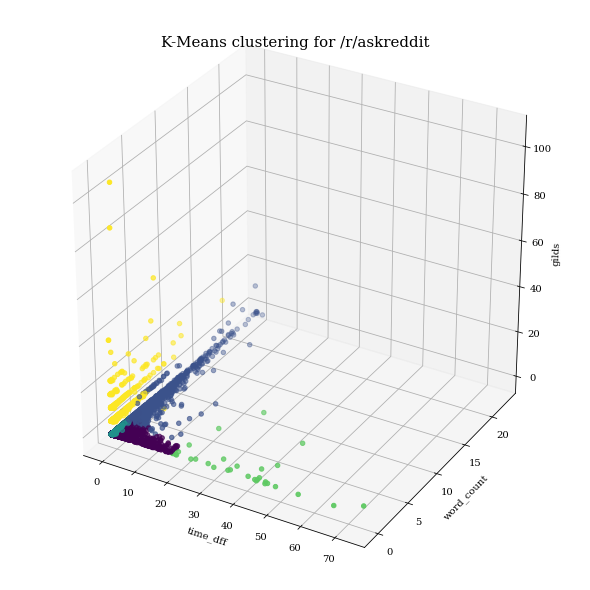

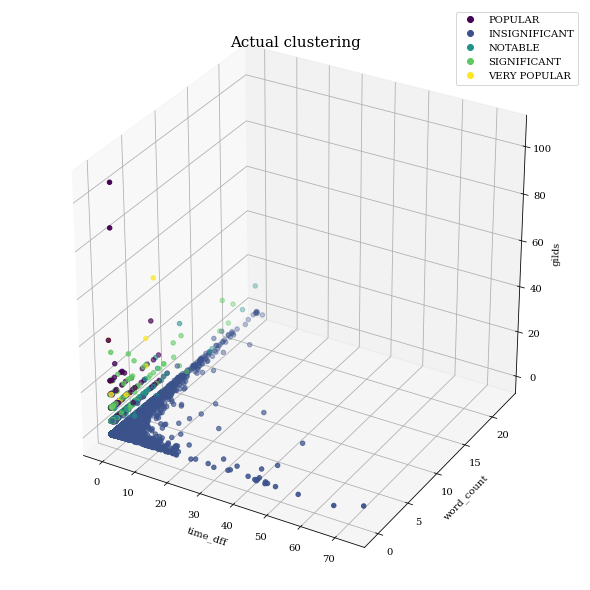

In [272]:
# plot params
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

# graph K-Means labelling
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
labels = clf.labels_

x_i, y_i, z_i = cat_id[xlab], cat_id[ylab], cat_id[zlab]
xlim = (None, None)

# limits
# ax.set_xlim(left=xlim[0],right=xlim[1])

# plot
ax.scatter(X[:,x_i], X[:,y_i], X[:,z_i], c=labels.astype(np.float))
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
ax.set_zlabel(zlab)
ax.set_title('K-Means clustering for /r/{0}'.format(subreddit), fontsize=15)
plt.show()

# graph actual labelling
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

# encode score categories in Y
Y_new, cat = pd.factorize(Y)

# limits
# ax.set_xlim(left=xlim[0],right=xlim[1])

# plot
sct = ax.scatter(X[:,x_i], X[:,y_i], X[:,z_i], c=Y_new.astype(np.float))
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
ax.set_zlabel(zlab)
ax.set_title('Actual clustering', fontsize=15)
ax.legend(handles=sct.legend_elements()[0],
          labels=list(cat))
plt.show()

Looking at the clusterings above, almost for any combination of axes we choose, we see a large number of insignificant comments (represented by each point). The K-Means model fit has a difficult time finding any distinct distancing pattern, meaning that a simple distance metric between all features is likely too simple to make any decent prediction. At the very least, we can see a loose correlation between the score and number of gilds in a particular comment.

To get a better look for any possible feature relationships, comments labeled `INSIGNIFICANT` will be dropped. For consistency, we will re-fit the K-Means model on the truncated data.

In [273]:
# drop insignificant rows
X_trunc_pre = data.drop(data[data['score_cat']=='INSIGNIFICANT'].index)
X_trunc_pre = X_trunc_pre.drop(columns=cols_to_drop)
X_trunc = full_pipeline.fit_transform(X_trunc_pre)

Y_trunc = data['score_cat']
Y_trunc = Y_trunc[Y_trunc != 'INSIGNIFICANT']

# re-fit, now we have 4 categories
N = 4 
clf_trunc = KMeans(n_clusters=N)
clf_trunc.fit(X_trunc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

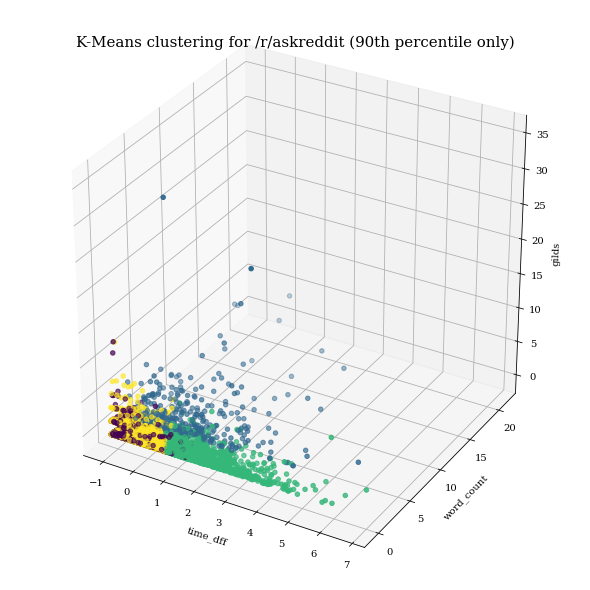

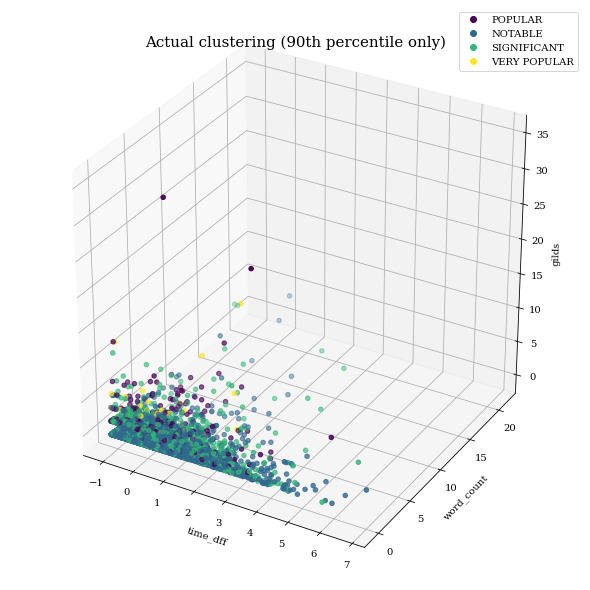

In [275]:
# dictionary of axes names to column index (i.e X[:,cat_id[i]])
cat_id = dict(zip(columns, range(len(columns))))
xlab = 'time_dff'
ylab = 'word_count'
zlab = 'gilds'
# category validity check
assert all([i in columns for i in (xlab,ylab,zlab)]),\
    'All chosen axes must be valid categories'

# graph K-Means labelling
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
labels = clf_trunc.labels_

x_i, y_i, z_i = cat_id[xlab], cat_id[ylab], cat_id[zlab]
xlim = (None, None)

# time_dff = 1, sentiment = 4, word_count = 5
ax.scatter(X_trunc[:,x_i], X_trunc[:,y_i], X_trunc[:,z_i], c=labels.astype(np.float))
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
ax.set_zlabel(zlab)
ax.set_title('K-Means clustering for /r/{0} (90th percentile only)'.format(subreddit), fontsize=15)
# limits
ax.set_xlim(left=xlim[0],right=xlim[1])
plt.show()

# graph actual labelling
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

# encode score categories in Y
Y_new, cat = pd.factorize(Y_trunc)

# time_dff = 1, sentiment = 4, word_count = 5
sct = ax.scatter(X_trunc[:,x_i], X_trunc[:,y_i], X_trunc[:,z_i], c=Y_new.astype(np.float))
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
ax.set_zlabel(zlab)
ax.set_title('Actual clustering (90th percentile only)', fontsize=15)
ax.legend(handles=sct.legend_elements()[0],
          labels=list(cat))
# limits
ax.set_xlim(left=xlim[0],right=xlim[1])
plt.show()

As seen above, even with the insignificant comments (which add a lot of noise in the data) removed, there is no easily-discernable split between each of the categories. However, under a selection of certain axes, one may observe a _loose_ pattern, namely a consistent gradient of score relative to features like `gilds`. In other words, K-Means classification without much more pre-processing and analysis _at the very least_ is not a good option for our task.

While this may be further explored, it makes more sense to explore other classification options like decision tree classifiers, random forests, PCA, LDA, and more.